In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['JAX_PLATFORMS']="cpu"
# os.environ['JAX_PLATFORMS']="cuda"

In [3]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax

import numpy as np

from tqdm.auto import tqdm

from functools import partial

from flax import nnx

/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sys 
sys.path.append("examples/sbi-benchmarks")
sys.path.append("src/")

In [5]:
import sbibm
from utils.sbi_tasks import TwoMoons

from sbi_utils.flux1_model.model import FluxParams, Flux

from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.loss import ContinuousFMLoss

from flow_matching.utils import ModelWrapper

In [6]:
twomoons = TwoMoons()
task = twomoons.task
prior = twomoons.get_prior()
simulator = twomoons.get_simulator()
observation = twomoons.get_observation(1)

theta = prior.sample((10_000,))
xs = simulator(theta)

In [7]:
@partial(jax.jit, static_argnames=["size"])
def sample_prior(size):
    return jnp.array(prior.sample((size,)))

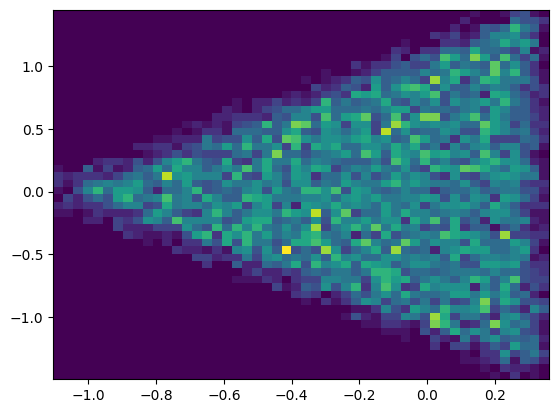

In [8]:
plt.hist2d(xs[:,0],xs[:,1], bins=50, density=True)
plt.show()

In [9]:
from sbibm.algorithms import rej_abc  # See help(rej_abc) for keywords
posterior_samples, _, _ = rej_abc(task=task, num_samples=10_000, num_observation=1, num_simulations=100_000)


Running REJ-ABC
Running 100000 simulations.: 100%|██████████| 100000/100000 [00:00<00:00, 1254814.11it/s]
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  F

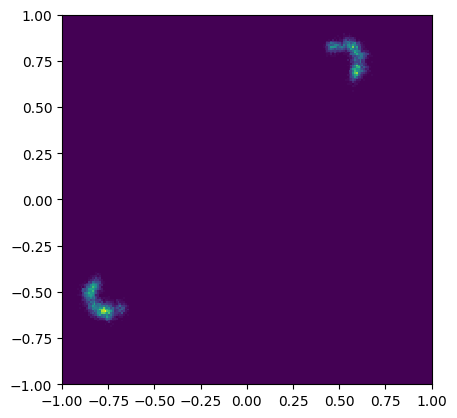

In [10]:
plt.hist2d(posterior_samples[:, 0], posterior_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [11]:
# Once we got samples from an approximate posterior, compare them to the reference:
from sbibm.metrics import c2st
reference_samples = task.get_reference_posterior_samples(num_observation=1)

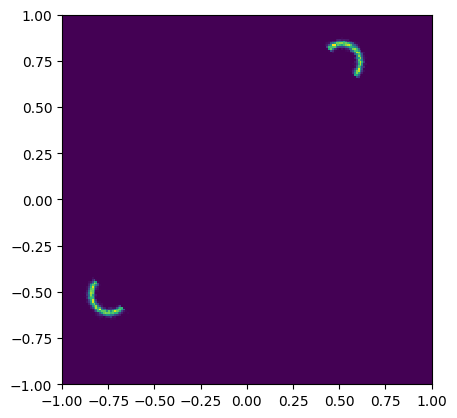

In [12]:
plt.hist2d(reference_samples[:, 0], reference_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [13]:
# c2st_accuracy = c2st(reference_samples, posterior_samples)

In [14]:
# c2st_accuracy # around 0.6

# dataset

In [15]:
# make a dataset
nsamples = int(1e5)
theta = prior.sample((nsamples,))
xs = jnp.array(simulator(theta))
node_ids = jnp.array(twomoons.get_node_id())
dim_theta = twomoons.get_theta_dim()
dim_x = twomoons.get_x_dim()

# turn them into jax arrays
theta = jnp.array(theta)
xs = jnp.array(xs)

# concatenate the data, theta and xs
data = jnp.concatenate((theta, xs), axis=-1)

val_perc = 0.05

train_size = int(nsamples * (1 - val_perc)) 

train_data = data[:train_size]
val_data = data[train_size:]


In [16]:
# make an infinite dataloader that shuffles the data once it finishes cycling it
class InfiniteDataLoader:
    def __init__(self, data, batch_size, *, rngs: nnx.Rngs):
        self.data = data
        self.batch_size = batch_size
        self.index = 0
        self.rngs = rngs

        self.data_mean = jnp.mean(data, axis=0)
        self.data_std = jnp.std(data, axis=0)

        # self.data = self.normalize(self.data)

    def normalize(self, unnormalized_data):
        # Normalize the data to be between 0 mean and unit varainve
        data = unnormalized_data - self.data_mean
        data = data / self.data_std

        return data

    def unnormalize(self, normdata):
        # Unnormalize the data
        data = normdata * self.data_std
        data = data + self.data_mean
        return data

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self._shuffle()
        batch = self.data[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return batch

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        return self.data[index]

    def _shuffle(self):
        self.data = jax.random.permutation(self.rngs.perm(), self.data)
        self.index = 0

In [17]:
batch_size = 1024
dataset = InfiniteDataLoader(train_data, batch_size, rngs=nnx.Rngs(0))

# define the CFM model

In [18]:
path = AffineProbPath(scheduler=CondOTScheduler()) # define the probability path

In [19]:
params=FluxParams(
            in_channels=1,
            vec_in_dim=None,
            context_in_dim=1,
            hidden_size=32,
            mlp_ratio=4.0,
            num_heads=8,
            depth=6,
            depth_single_blocks=2,
            axes_dim=[4,],
            theta=1_000,
            qkv_bias=True,
            guidance_embed=False,
            rngs=nnx.Rngs(default=42),
            param_dtype=jnp.bfloat16,
        )

In [20]:
vf_model = Flux(params)

In [21]:
# loss_fn_cfm = ContinuousFMLoss(path)

In [22]:
def loss_fn_cfm(vf, path, obs, cond, obs_ids, cond_ids, key):
    key1, key2 = jax.random.split(key, 2)

    x_1 = obs
    x_0 = jax.random.normal(key1, x_1.shape)
    t = jax.random.uniform(key2, x_1.shape[0])

    path_sample = path.sample(x_0, x_1, t)

    x_t = path_sample.x_t

    model_output = vf(x_t, obs_ids, cond, cond_ids, t)
    
    loss = model_output - path_sample.dx_t

    return jnp.mean(jnp.square(loss))

In [23]:
test_data = val_data
obs = test_data[:,:2][...,None]
cond = test_data[:,2:][...,None]

obs_ids = jnp.arange(2, dtype=jnp.int32).reshape(1,-1,1)
cond_ids = jnp.arange(2, dtype=jnp.int32).reshape(1,-1,1)

In [24]:
loss_fn_cfm(vf_model, path, obs, cond, obs_ids, cond_ids, jax.random.PRNGKey(0))

Array(2.522613, dtype=float32)

In [25]:
from numpyro import distributions as dist

p0_dist_model = dist.Independent(
    dist.Normal(loc=jnp.zeros((4,)), scale=jnp.ones((4,))),
    reinterpreted_batch_ndims=1
)

In [26]:
def loss_fn_(vf_model, key: jax.random.PRNGKey):
    batch = next(dataset)
    obs = batch[:,:2][...,None]
    cond = batch[:,2:][...,None]

    obs_ids = jnp.arange(2, dtype=jnp.int32).reshape(1,-1,1)
    cond_ids = jnp.arange(2, dtype=jnp.int32).reshape(1,-1,1)

    loss=loss_fn_cfm(vf_model, path, obs, cond, obs_ids, cond_ids, key)
    return loss

def val_loss(vf_model, key: jax.random.PRNGKey):
    batch = val_data
    obs = batch[:,:2][...,None]
    cond = batch[:,2:][...,None]

    obs_ids = jnp.arange(2, dtype=jnp.int32).reshape(1,-1,1)
    cond_ids = jnp.arange(2, dtype=jnp.int32).reshape(1,-1,1)

    loss=loss_fn_cfm(vf_model, path, obs, cond, obs_ids, cond_ids, key)
    return loss

In [27]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: loss_fn_(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.
    return loss

In [28]:
optimizer = nnx.Optimizer(vf_model, optax.adam(1e-4))  
train_step(vf_model, optimizer, nnx.Rngs(0).dist()) # ensure that the model is working and compile the function

Array(2.423784, dtype=float32)

In [29]:
rngs = nnx.Rngs(0)

In [104]:
best_state = nnx.state(vf_model)
val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
counter = 0
cmax = 50
print_every = 100


nepochs = 5
schedule = optax.schedules.exponential_decay(1e-3, 
                                             1e6, 
                                             decay_rate = 0.2, 
                                             transition_begin = 2000, 
                                             end_value = 1e-6)

# optimizer = nnx.Optimizer(vf_model, optax.adam(schedule))  
optimizer = nnx.Optimizer(vf_model, optax.adam(1e-4)) 


vf_model.train()

for ep in range(nepochs):
    pbar = tqdm(range(10000))
    l = 0
    for j in pbar:
        if counter > cmax:
            print("Early stopping")
            # restore the model state
            graphdef, abstract_state = nnx.split(vf_model)

            vf_model = nnx.merge(graphdef, best_state)
            break
        
        key_ = rngs.train_step()
        loss = train_step(vf_model, optimizer, key_)
        l += loss.item()
        if j % 100 == 0:
            val_ = val_loss(vf_model, rngs.val_step())
            if val_ < val_loss_value:
                val_loss_value = val_
                counter = 0
                best_state = nnx.state(vf_model)
            else:
                counter += 1
            pbar.set_postfix(loss=f"{l/(100):.4f}", val_loss=f"{val_:.4f}", counter=counter)
            l=0
    # print(l)



vf_model.eval()

 56%|█████▌    | 5601/10000 [03:12<02:31, 29.06it/s, counter=51, loss=0.5225, val_loss=0.1644]


Early stopping


  0%|          | 0/10000 [00:00<?, ?it/s]


Early stopping


  0%|          | 0/10000 [00:00<?, ?it/s]


Early stopping


  0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping


# model wrapper

In [83]:
from einops import rearrange

class FluxWrapper(ModelWrapper):
    def __init__(self, model):
        super().__init__(model)

    def __call__(self, x, t, args, **kwargs):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')
        # t = t.reshape(-1,1, 1)
        return jnp.squeeze(self.model(obs=x, timesteps=t, **kwargs), axis=-1)

# sample the posterior

In [34]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
observation = jnp.array(twomoons.get_observation(1))

In [35]:
observation.shape

(1, 2)

In [79]:
rng = jax.random.PRNGKey(45)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

nsamples = 1_000 #reference_samples.shape[0]

# x_init = jnp.zeros((nsamples, dim_joint))  # initial conditions
key1,key2 = jax.random.split(rng, 2)

x_init = jax.random.normal(key1,(nsamples, dim_x)) # n, T_max, 1
cond = jnp.broadcast_to(observation[...,None], (nsamples, dim_theta, 1)) # n, dim_theta, 1


In [ ]:
vf_model(x_init[...,None], obs_ids, cond, cond_ids, jnp.array([1.0])).shape

ValueError: Input obs and cond tensors must have 3 dimensions.

In [81]:
vf_wrapped = FluxWrapper(vf_model)

In [84]:
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}
vf_wrapped(x_init, jnp.array([1.0]), None, **model_extras).shape

(1000, 2)

In [85]:
cond_ids = jnp.arange(dim_theta, dtype=jnp.int32).reshape(1,-1,1)
obs_ids = jnp.arange(dim_x, dtype=jnp.int32).reshape(1,-1,1)

In [ ]:
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
# model_extras = {"node_ids": jnp.array([0, 1, 2, 3]), "edge_mask": undirected_edge_mask}
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

sampler_ = solver.get_sampler(time_grid=T, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
samples = sampler_(x_init)  # sample from the model

# sampler_ = solver.get_sampler(time_grid=T, condition_mask=condition_mask, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
# samples = sampler_(x_init)  # sample from the model

# samples = dataset.unnormalize(samples)

In [71]:
rng = jax.random.PRNGKey(45)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

nsamples = 100_000 #reference_samples.shape[0]

# x_init = jnp.zeros((nsamples, dim_joint))  # initial conditions
key1,key2 = jax.random.split(rng, 2)
x_init = p0_dist_model.sample(key1, (nsamples,))
# noise = jnp.zeros((batch_size, dim_x)) # n, T_max, 1
# noise = jax.random.normal(key2, (batch_size, dim_x)) # n, T_max, 1
# x_init = jnp.concatenate([samples_prior, noise], axis=-1)


# x_init = jax.random.normal(rng, (nsamples, dim_joint))  # initial conditions
condition_mask = jnp.array([0,0,1,1], dtype=jnp.bool_)  # condition on the data, obtain the 2d posterior


x_init = x_init.at[:, 2].set(observation[0,0]) # set the conditioned values
x_init = x_init.at[:, 3].set(observation[0,1]) # set the conditioned values


solver = ODESolver(velocity_model=vf_model)  # create an ODESolver class
# model_extras = {"node_ids": jnp.array([0, 1, 2, 3]), "edge_mask": undirected_edge_mask}
model_extras = {"node_ids": jnp.array([0, 1, 2, 3]), "edge_mask": posterior_faithfull}
sampler_ = solver.get_sampler(time_grid=T, condition_mask=condition_mask, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
samples = sampler_(x_init)  # sample from the model

# samples = dataset.unnormalize(samples)

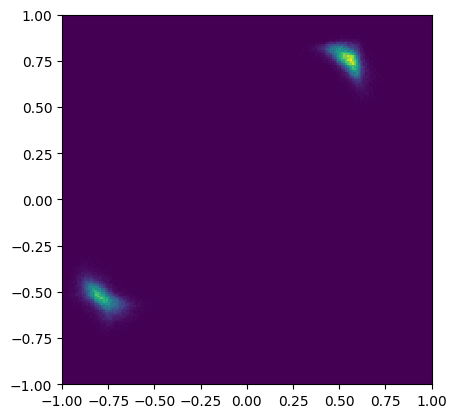

In [72]:
posterior_samples = samples[:,0:2]

plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

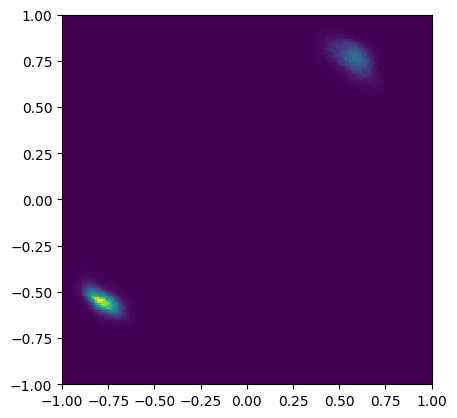

# evaluate the posterior

In [93]:
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-1, 1, grid_size), jnp.linspace(-1, 1, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

In [94]:
x_1.shape

(40000, 2)

In [95]:
observation[0,2]

Array(0.16234657, dtype=float32)

In [96]:
# get the logprob
logp_sampler = solver.get_unnormalized_logprob(condition_mask=condition_mask, time_grid=[1.0,0.0],method='dopri5', step_size=step_size, log_p0=p0_dist_model.log_prob, model_extras=model_extras)
# create an y_init which has theta on the first position and x1,x2 on the second and third position
y_init = jnp.zeros((x_1.shape[0], 4))
y_init = y_init.at[:,0].set(x_1[:,0])
y_init = y_init.at[:,1].set(x_1[:,1])
y_init = y_init.at[:,2].set(observation[0,0])
y_init = y_init.at[:,3].set(observation[0,1])

_ , exact_log_p = logp_sampler(y_init)
p = jnp.exp(exact_log_p)[-1]
# # # normalize the distribution
# n = jax.scipy.integrate.trapezoid(p, theta)
# p = p/n


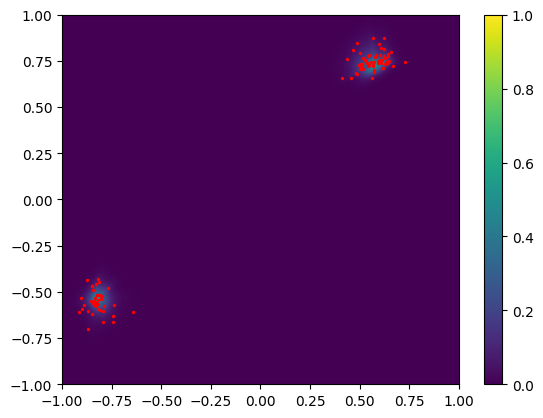

In [97]:
p_grid = p.reshape((grid_size, grid_size))
plt.imshow(p_grid, origin='lower', aspect='auto', extent=(-1, 1, -1, 1), cmap='viridis', vmin=0, vmax=10)
plt.scatter(posterior_samples[:100,0], posterior_samples[:100,1], alpha=1, color='red', s=2)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.colorbar()
plt.show()

# generation with guidance

In [98]:
cfg_scale = 0.80

rng = jax.random.PRNGKey(45)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

nsamples = 100_000 #reference_samples.shape[0]

# x_init = jnp.zeros((nsamples, dim_joint))  # initial conditions
key1,key2 = jax.random.split(rng, 2)
x_init = p0_dist_model.sample(key1, (nsamples,))
# noise = jnp.zeros((batch_size, dim_x)) # n, T_max, 1
# noise = jax.random.normal(key2, (batch_size, dim_x)) # n, T_max, 1
# x_init = jnp.concatenate([samples_prior, noise], axis=-1)


# x_init = jax.random.normal(rng, (nsamples, dim_joint))  # initial conditions
condition_mask = jnp.array([0,0,1,1], dtype=jnp.bool_)  # condition on the data, obtain the 2d posterior


x_init = x_init.at[:, 2].set(observation[0,0]) # set the conditioned values
x_init = x_init.at[:, 3].set(observation[0,1]) # set the conditioned values


solver = ODESolver(velocity_model=vf_model)  # create an ODESolver class
# model_extras = {"node_ids": jnp.array([0, 1, 2, 3]), "edge_mask": undirected_edge_mask}
model_extras = {"node_ids": jnp.array([0, 1, 2, 3]), "edge_mask": posterior_faithfull}
sampler_ = solver.get_sampler(time_grid=T, cfg_scale=cfg_scale, condition_mask=condition_mask, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
samples = sampler_(x_init)  # sample from the model

# samples = dataset.unnormalize(samples)

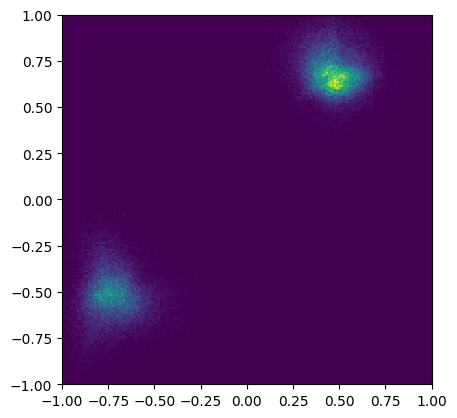

In [99]:
posterior_samples_cfg = samples[:,0:2]

plt.hist2d(posterior_samples_cfg[:,0], posterior_samples_cfg[:,1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

# C2ST test

In [100]:
# convert posterior samples to a torch array
import torch
posterior_samples_cfg_torch = torch.tensor(np.array(posterior_samples_cfg))
posterior_samples_torch = torch.tensor(np.array(posterior_samples))

In [101]:
c2st_accuracy_cfg = c2st(reference_samples, posterior_samples_cfg_torch)
c2st_accuracy = c2st(reference_samples, posterior_samples_torch)

In [102]:
c2st_accuracy_cfg, c2st_accuracy

(tensor([0.9337]), tensor([0.9192]))